# Lab 2: Black-Box Evasion Attacks

## Overview

In this lab, you'll learn how to attack machine learning models when you have limited access - no gradients, no model weights, just query access. This represents the most realistic threat scenario for production systems.

## Learning Objectives

By the end of this lab, you will:
1. Understand black-box threat models
2. Implement SimBA (score-based attack)
3. Execute HopSkipJump (decision-based attack)
4. Evaluate query efficiency and stealth
5. Apply operational security principles

## Prerequisites

- Completion of Lab 1 (White-box evasion)
- Understanding of gradient-based attacks
- Python and PyTorch basics

## Setup

### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Import our HopSkipJump utility
import sys
sys.path.append('../utils')
from hop_skip_jump import HopSkipJump

# Detect device (supports CUDA, Apple Silicon MPS, and CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✓ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
    print("✓ Using Apple Silicon GPU (MPS)")
else:
    device = torch.device('cpu')
    print("ℹ Using CPU")

print(f"Device: {device}")

✓ Using Apple Silicon GPU (MPS)
Device: mps


### Load Model and Data

In [2]:
# Load pre-trained model
model = torchvision.models.mobilenet_v2(pretrained=True)
model.eval()
model.to(device)

# Define preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Unnormalize for visualization
unnormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

print("✓ Model and transforms loaded")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/schwartz/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


/Users/schwartz/src/genai-security-training/.venv/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/schwartz/src/genai-security-training/.venv/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 13.6M/13.6M [00:07<00:00, 1.79MB/s]


✓ Model and transforms loaded


## Part 1: SimBA Attack (Score-Based)

SimBA (Simple Black-box Attack) works when you have access to confidence scores but not gradients.

### Understanding SimBA

**Key Idea**: Generate random perturbations and keep those that reduce the target class score.

**Algorithm**:
1. Generate random masks
2. Test each mask
3. Keep masks that improve attack
4. Iterate until misclassification

In [3]:
def simba_attack(model, img_tensor, target_class, n_masks=1000, eta=0.005, max_queries=10000):
    """
    SimBA attack implementation (untargeted)
    
    Args:
        model: Target model
        img_tensor: Input image
        target_class: Original class to attack
        n_masks: Number of random masks
        eta: Perturbation size
        max_queries: Maximum queries allowed
        
    Returns:
        adversarial_image, queries_used, success
    """
    # Generate random masks
    mask_collection = torch.randn((n_masks, *img_tensor.shape), device=img_tensor.device) * eta
    current_mask = torch.zeros_like(img_tensor)
    
    # Get starting score
    with torch.no_grad():
        starting_score = model(img_tensor + current_mask)[0, target_class].item()
    
    best_score = starting_score
    queries = 0
    starting_label = target_class
    current_label = starting_label
    
    # Attack loop
    print(f"Starting SimBA attack (untargeted)...")
    print(f"Initial score for class {target_class}: {starting_score:.4f}")
    
    while current_label == starting_label and queries < max_queries:
        # Select random mask
        mask_idx = np.random.choice(len(mask_collection))
        mask_candidate = mask_collection[mask_idx]
        
        # Test candidate
        with torch.no_grad():
            output = model(img_tensor + current_mask + mask_candidate)
            queries += 1
        
        current_label = output.argmax(1).item()
        new_score = output[0, starting_label].item()
        
        # Keep if improves attack (reduces original class score)
        if new_score < best_score:
            best_score = new_score
            current_mask += mask_candidate
            if queries % 100 == 0:
                print(f"Query {queries}: score={best_score:.4f}, pred={current_label}", end='\r')
    
    success = (current_label != starting_label)
    print(f"\n{'✓ Success' if success else '✗ Failed'}: {queries} queries, final class={current_label}")
    
    return img_tensor + current_mask, queries, success

print("✓ SimBA attack function defined")

✓ SimBA attack function defined


### Run SimBA Attack

Let's test SimBA on a sample image.

In [4]:
# Create a simple test image (or load your own)
# For demo, we'll create a random image that classifies as something
torch.manual_seed(42)
test_img = torch.randn(1, 3, 224, 224).to(device)
test_img = torch.clamp(test_img, -2, 2)  # Clip to valid range

# Get original prediction
with torch.no_grad():
    orig_output = model(test_img)
    orig_class = orig_output.argmax(1).item()
    orig_conf = torch.softmax(orig_output, dim=1)[0, orig_class].item()

print(f"Original prediction: class {orig_class} ({orig_conf:.2%} confidence)")

# Run SimBA attack
adv_simba, queries_simba, success_simba = simba_attack(
    model, test_img, orig_class, n_masks=1000, eta=0.01, max_queries=5000
)

Original prediction: class 644 (6.51% confidence)
Starting SimBA attack (untargeted)...
Initial score for class 644: 6.2317

✓ Success: 28 queries, final class=446


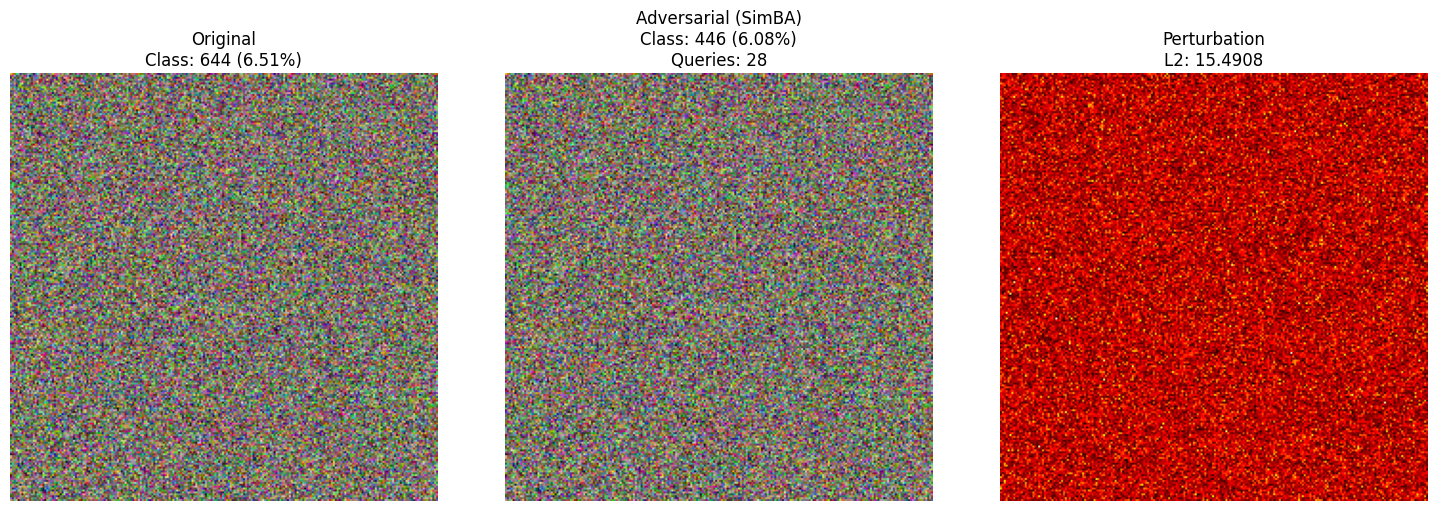


Perturbation Statistics:
  L2 norm: 15.4908
  L∞ norm: 0.1912
  Mean: 0.031855


In [5]:
# Visualize results
with torch.no_grad():
    adv_output = model(adv_simba)
    adv_class = adv_output.argmax(1).item()
    adv_conf = torch.softmax(adv_output, dim=1)[0, adv_class].item()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original
axes[0].imshow(unnormalize(test_img[0]).cpu().permute(1, 2, 0).clamp(0, 1))
axes[0].set_title(f'Original\nClass: {orig_class} ({orig_conf:.2%})')
axes[0].axis('off')

# Adversarial
axes[1].imshow(unnormalize(adv_simba[0]).cpu().permute(1, 2, 0).clamp(0, 1))
axes[1].set_title(f'Adversarial (SimBA)\nClass: {adv_class} ({adv_conf:.2%})\nQueries: {queries_simba}')
axes[1].axis('off')

# Perturbation
perturbation = (adv_simba - test_img).abs()
axes[2].imshow(perturbation[0].cpu().permute(1, 2, 0).mean(dim=2), cmap='hot')
axes[2].set_title(f'Perturbation\nL2: {torch.norm(perturbation).item():.4f}')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"\nPerturbation Statistics:")
print(f"  L2 norm: {torch.norm(perturbation).item():.4f}")
print(f"  L∞ norm: {perturbation.max().item():.4f}")
print(f"  Mean: {perturbation.mean().item():.6f}")

### Exercise 1: Targeted SimBA Attack

**Task**: Modify the SimBA attack to target a specific class.

**Hint**: Instead of reducing the original class score, increase the target class score.

In [6]:
def simba_targeted_attack(model, img_tensor, original_class, target_class, n_masks=1000, eta=0.01, max_queries=10000):
    """
    TODO: Implement targeted SimBA attack
    
    Args:
        model: Target model
        img_tensor: Input image
        original_class: Original predicted class
        target_class: Desired target class
        n_masks: Number of random masks
        eta: Perturbation size
        max_queries: Maximum queries allowed
        
    Returns:
        adversarial_image, queries_used, success
    """
    # YOUR CODE HERE
    # Hint: Change the condition to check if target_class score increases
    pass

# Test your implementation
# target_idx = 15  # Choose a target class
# adv_targeted, queries_targeted, success_targeted = simba_targeted_attack(
#     model, test_img, orig_class, target_idx
# )

## Part 2: HopSkipJump Attack (Decision-Based)

HopSkipJump works with only class labels - the hardest and most realistic scenario.

### Understanding HopSkipJump

**Key Idea**: 
1. Find any misclassified sample
2. Binary search to decision boundary
3. Estimate gradient via random sampling
4. Walk along boundary toward original image

**Why it's powerful**: Works with minimal information (just predicted class).

In [7]:
# Create attacker
attacker = HopSkipJump(
    model=model,
    norm=2,              # L2 norm
    max_iter=64,         # Number of iterations
    max_eval=10000,      # Max evaluations per iteration
    init_eval=100,       # Initial evaluations
    clip_min=-2.0,       # Min pixel value (normalized)
    clip_max=2.0,        # Max pixel value (normalized)
    verbose=True
)

print("✓ HopSkipJump attacker created")

✓ HopSkipJump attacker created


In [8]:
# Run attack
print("\nRunning HopSkipJump Attack...")
adv_hsj, info_hsj = attacker.attack(test_img, torch.tensor([orig_class]).to(device))

# Check results
print(f"\nHopSkipJump Results:")
print(f"  Success: {info_hsj['success'][0]}")
print(f"  Queries: {info_hsj['queries'][0]}")
print(f"  L2 Distance: {info_hsj['distances'][0]:.4f}")


Running HopSkipJump Attack...

[*] Attacking sample 1/1
[+] Found initial adversarial sample (attempt 14)


HSJ iterations: 100%|██████████| 64/64 [13:26<00:00, 12.60s/it, dist=0.1854, queries=33174]

[+] Attack successful!
    Final distance: 0.1815
    Total queries: 35605

[*] Attack complete
    Success rate: 1/1
    Total queries: 35605
    Avg queries per sample: 35605

HopSkipJump Results:
  Success: True
  Queries: 35605
  L2 Distance: 0.1815


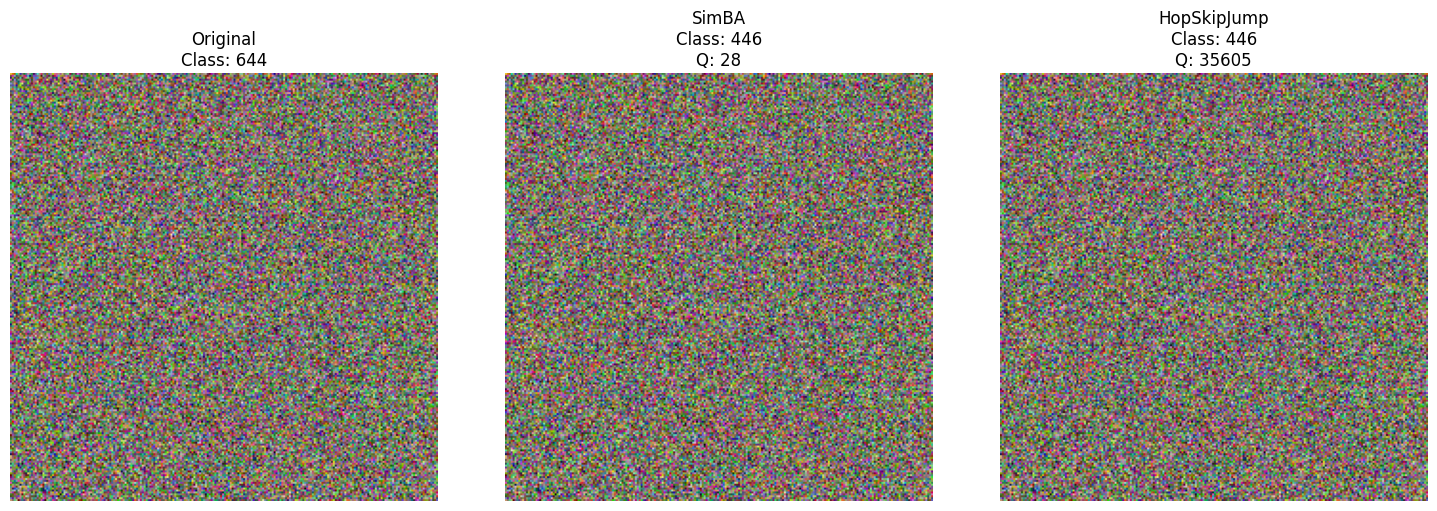

In [9]:
# Visualize HSJ results
with torch.no_grad():
    hsj_output = model(adv_hsj)
    hsj_class = hsj_output.argmax(1).item()
    hsj_conf = torch.softmax(hsj_output, dim=1)[0, hsj_class].item()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original
axes[0].imshow(unnormalize(test_img[0]).cpu().permute(1, 2, 0).clamp(0, 1))
axes[0].set_title(f'Original\nClass: {orig_class}')
axes[0].axis('off')

# SimBA
axes[1].imshow(unnormalize(adv_simba[0]).cpu().permute(1, 2, 0).clamp(0, 1))
axes[1].set_title(f'SimBA\nClass: {adv_class}\nQ: {queries_simba}')
axes[1].axis('off')

# HopSkipJump
axes[2].imshow(unnormalize(adv_hsj[0]).cpu().permute(1, 2, 0).clamp(0, 1))
axes[2].set_title(f'HopSkipJump\nClass: {hsj_class}\nQ: {info_hsj["queries"][0]}')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Part 3: Comparison and Analysis

### Query Efficiency


Attack Comparison:
     Attack  Queries  Success  L2 Distance
      SimBA       28     True    15.490831
HopSkipJump    35605     True     0.181478


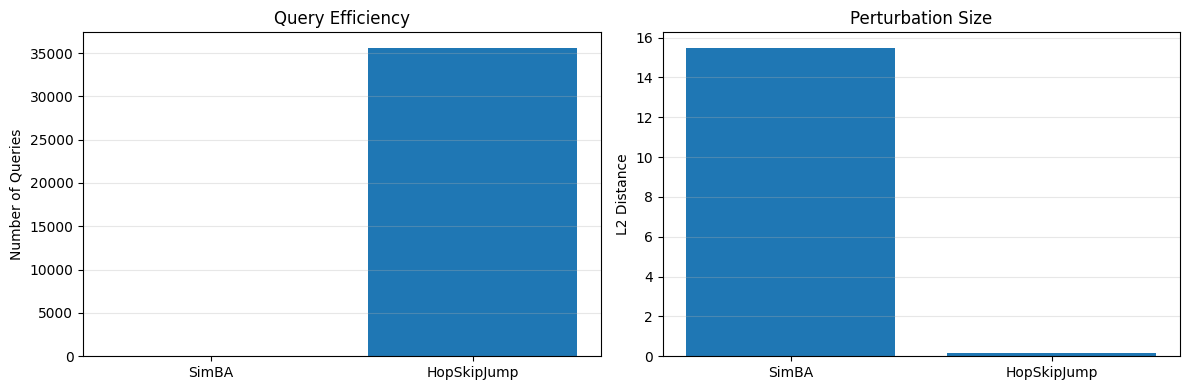

In [10]:
# Compare query efficiency
import pandas as pd

comparison = {
    'Attack': ['SimBA', 'HopSkipJump'],
    'Queries': [queries_simba, info_hsj['queries'][0]],
    'Success': [success_simba, info_hsj['success'][0]],
    'L2 Distance': [
        torch.norm(adv_simba - test_img).item(),
        info_hsj['distances'][0]
    ]
}

df = pd.DataFrame(comparison)
print("\nAttack Comparison:")
print(df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(df['Attack'], df['Queries'])
axes[0].set_ylabel('Number of Queries')
axes[0].set_title('Query Efficiency')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(df['Attack'], df['L2 Distance'])
axes[1].set_ylabel('L2 Distance')
axes[1].set_title('Perturbation Size')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Part 4: Red Team Considerations

### Operational Security

In [11]:
def analyze_query_budget(queries_used, cost_per_query=0.001, time_per_query=0.1):
    """
    Analyze operational costs of attack
    
    Args:
        queries_used: Number of queries
        cost_per_query: Cost per API call ($)
        time_per_query: Time per query (seconds)
    """
    total_cost = queries_used * cost_per_query
    total_time = queries_used * time_per_query
    
    print(f"\nOperational Analysis:")
    print(f"  Queries: {queries_used}")
    print(f"  Estimated cost: ${total_cost:.2f}")
    print(f"  Estimated time: {total_time/60:.1f} minutes")
    print(f"  Queries per minute: {60/time_per_query:.0f}")
    
    # Detection risk
    if queries_used > 10000:
        print(f"  ⚠️  HIGH detection risk (>10k queries)")
    elif queries_used > 5000:
        print(f"  ⚠️  MEDIUM detection risk (>5k queries)")
    else:
        print(f"  ✓ LOW detection risk (<5k queries)")

# Analyze both attacks
print("SimBA:")
analyze_query_budget(queries_simba)

print("\nHopSkipJump:")
analyze_query_budget(info_hsj['queries'][0])

SimBA:

Operational Analysis:
  Queries: 28
  Estimated cost: $0.03
  Estimated time: 0.0 minutes
  Queries per minute: 600
  ✓ LOW detection risk (<5k queries)

HopSkipJump:

Operational Analysis:
  Queries: 35605
  Estimated cost: $35.61
  Estimated time: 59.3 minutes
  Queries per minute: 600
  ⚠️  HIGH detection risk (>10k queries)


## Summary

### Key Takeaways

1. **Black-box attacks work** with limited information
2. **SimBA** is efficient when you have confidence scores
3. **HopSkipJump** works with only class labels
4. **Query efficiency** is critical for stealth
5. **Operational security** matters in real attacks

### Attack Comparison

| Attack | Information Needed | Queries | Stealth | Difficulty |
|--------|-------------------|---------|---------|------------|
| FGSM (Lab 1) | Gradients | 1 | N/A | Easy |
| PGD (Lab 1) | Gradients | 10-100 | N/A | Easy |
| SimBA | Confidence scores | 1,000-5,000 | Medium | Medium |
| HopSkipJump | Class labels only | 5,000-20,000 | Low | Hard |

### When to Use Each

- **White-box (Lab 1)**: Research, model analysis
- **SimBA**: API with confidence scores
- **HopSkipJump**: API with only predictions
- **Transfer**: No query access at all

## Next Steps

1. Complete exercises
2. Try different models and images
3. Experiment with parameters
4. Move to Lab 3: Text Adversarial Attacks

## References

1. "Simple Black-box Adversarial Attacks" (Guo et al., 2019)
2. "HopSkipJumpAttack: A Query-Efficient Decision-Based Attack" (Chen et al., 2020)
3. Adversarial Robustness Toolbox: https://github.com/Trusted-AI/adversarial-robustness-toolbox